![Kickstarer](./images/kickstarter.png)

---
Imports
---

In [258]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from collections import Counter
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [126]:
# Import the .csv files and concat them into one dataframe
original_dataframe = pd.concat(map(pd.read_csv, glob.glob('data/data-2/*.csv')))

In [127]:
# Set a working dataframe, so that we don't have to wait 10s it to import again if we want to start fresh
df = original_dataframe

---
EDA - Part 1
---

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 3791
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obj

In [129]:
df.isnull().sum()

backers_count                    0
blurb                            8
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
friends                     208922
fx_rate                          0
goal                             0
id                               0
is_backing                  208922
is_starrable                     0
is_starred                  208922
launched_at                      0
location                       226
name                             0
permissions                 208922
photo                            0
pledged                          0
profile                          0
slug                             0
source_url          

In [130]:
# Only a very limited amount of suspended projects (drop), canceled projects will be treated as though they failed
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [131]:
# Check for duplicate projects and store them in a table
dups = df.groupby(df.id.tolist()).size().reset_index().rename(columns={0:'count'})
# Sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

26958

---
Data Cleaning
---

In [132]:
# Drop features which will not be needed for further analysis
dropped_features = ['blurb', 'currency_symbol', 'backers_count', 'is_backing', 'permissions', 'is_starred', 'source_url',
                    'slug', 'name', 'static_usd_rate', 'profile', 'friends', 'spotlight', 'is_starrable', 'photo', 'pledged', 'usd_type',
                    'fx_rate', 'location', 'creator', 'currency_trailing_code','current_currency', 'created_at', 'urls']
df = df.drop(dropped_features, axis=1)

In [133]:
# Built array which contains live projects for later use 
array_live = ['live']
live_projects = df.loc[df['state'].isin(array_live)]

# Filter and concat. for target variable
array_notlive = ['successful', 'failed', 'canceled']
df = df.loc[df['state'].isin(array_notlive)]
df.replace('canceled','failed', inplace=True)


In [134]:
# Sort dataframe by 'date_changed_at' so that we will keep the entry that was most recently updated
df.sort_values('state_changed_at')
# Remove duplicates
duplicates = df.duplicated(subset='id', keep='last')
df = df[~duplicates]

---
Feature Engineering
---

In [135]:
#Extract category names from long string in 'category' column
list = []
for i, j in df['category'].iteritems():
    try:
        found = re.search('slug":"(.+?)/', j).group(1)
        list.append(found)
    except AttributeError:
        pass

list_2 = []
for i, j in enumerate(list):
    try:
        found = re.search('(.+?)"', j).group(1)
        list_2.append(found)
    except AttributeError:
        pass

# Add the categories and delete the original cluttered category
df['categories'] = pd.Series(list_2)
df.drop('category', axis=1, inplace=True)

In [136]:
# Generate new column with readable timeformat
df['launched_at_new'] = pd.to_datetime(df['launched_at'], unit='s')
df['deadline_new'] = pd.to_datetime(df['deadline'], unit='s')
df['state_changed_at_new'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [137]:
# Create new feature 'duration' that displays wheather the project timespan was more or less than 30 days
df = df.eval('duration = deadline - launched_at')
df['duration'] = ['over' if x > 2592000 else 'under' for x in df['duration']]

In [138]:
# Add new column 'time' that displays the time from project launch to project end
df.eval('time = state_changed_at_new - launched_at_new', inplace=True)

In [139]:
# Change dates to weekend(1) or weekday(0)
def change_time(dataframe, column_list):
    for column in column_list:
        dataframe[column] = [1 if x >= 6 else 0 for x in pd.to_datetime(dataframe[column], unit='s').dt.weekday]
    return dataframe

In [140]:
times_lst = ['launched_at', 'deadline', 'state_changed_at']
change_time(df, times_lst)

,converted_pledged_amount,country,currency,deadline,disable_communication,goal,id,launched_at,staff_pick,state,state_changed_at,usd_pledged,categories,launched_at_new,deadline_new,state_changed_at_new,duration,time
1,1950,US,USD,0,False,1000.0,928751314,0,False,successful,0,1950.000000,photography,2017-08-10 17:00:59,2017-09-09 17:00:59,2017-09-09 17:00:59,under,30 days 00:00:00
2,22404,US,USD,0,False,15000.0,928014092,0,False,successful,0,22404.000000,fashion,2013-05-13 05:03:15,2013-06-12 05:03:15,2013-06-12 05:03:15,under,30 days 00:00:00
3,165,GB,GBP,0,False,10000.0,596091328,0,False,failed,0,165.384934,music,2017-01-12 18:22:56,2017-03-13 17:22:56,2017-03-13 17:22:56,over,59 days 23:00:00
4,2820,US,USD,0,False,2800.0,998516049,0,False,successful,0,2820.000000,photography,2012-12-10 20:32:07,2013-01-09 20:32:07,2013-01-09 20:32:07,under,30 days 00:00:00
5,3725,US,USD,0,False,3500.0,1224600291,0,False,successful,0,3725.000000,theater,2015-04-02 02:25:46,2015-05-02 02:25:46,2015-05-02 02:25:46,under,30 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,8924,US,USD,0,False,1500.0,1011591139,0,False,successful,0,8924.000000,photography,2018-11-27 22:38:32,2018-12-12 04:45:00,2018-12-12 04:45:01,under,14 days 06:06:29
3788,5710,NL,EUR,0,False,5000.0,4607750,1,False,successful,0,5575.830204,theater,2017-05-14 17:21:54,2017-06-19 22:00:00,2017-06-19 22:00:00,over,36 days 04:38:06
3789,2681,US,USD,0,False,2500.0,67097337,0,False,successful,0,2681.000000,photography,2012-08-14 20:36:30,2012-09-17 03:59:00,2012-09-17 03:59:01,over,33 days 07:22:31
3790,5692,US,USD,0,False,5500.0,1031742546,0,False,successful,0,5692.000000,theater,2015-03-21 13:26:15,2015-04-20 13:26:15,2015-04-20 13:26:19,under,30 days 00:00:04


In [238]:
df[['converted_pledged_amount','goal']].describe().round()
#There needs to be an outlier analysis on those two values

,converted_pledged_amount,goal
count,177603.0,177603.0
mean,11601.0,52111.0
std,81724.0,1228707.0
min,0.0,0.0
25%,70.0,1500.0
50%,1260.0,5000.0
75%,5900.0,15000.0
max,8596474.0,100000000.0


---
EDA - Part 2
---

##### Plots

In [191]:
# Which data needs to be plotted categorical and which numerical
categorical = ['country','currency', 'staff_pick', 'categories','duration']
numerical = ['usd_pledged', 'goal', 'converted_pledged_amount']

In [189]:
def bar_plot(df, column):
    """Generates barplots of categorical data

    Args:
        df (pd dataframe): Dataframe
        column (object): list of names of columns which should be plotted
    """
    # get feature
    for i in column:
        varValue = df[i].value_counts()

        plt.figure(figsize = (12,3))
        plt.bar(varValue.index, varValue, color = '#87c442', edgecolor = 'black')
        plt.xticks(varValue.index, varValue.index.values)
        plt.ylabel("Frequency")
        plt.title(i.capitalize())
        plt.xticks(rotation = 90)
        plt.show()
    


##### Categorical Data

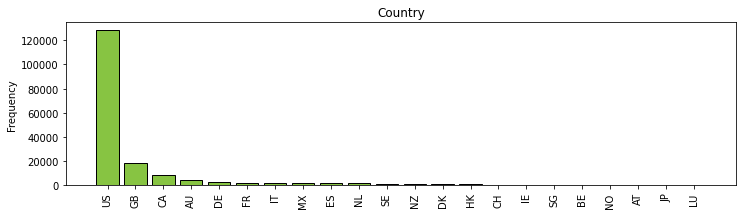

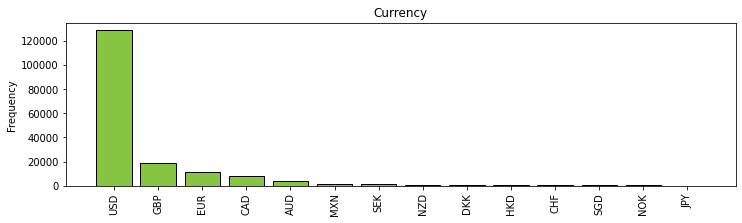

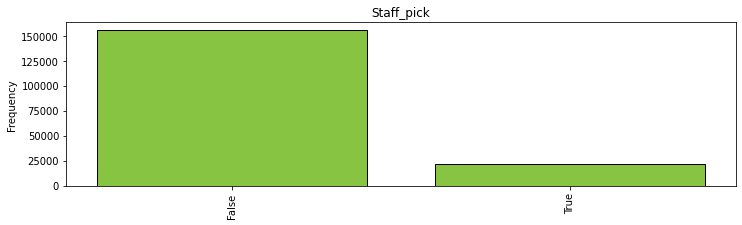

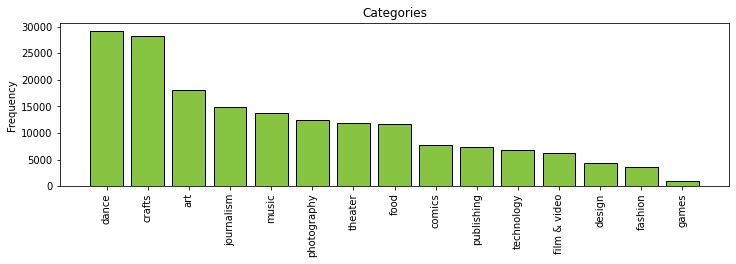

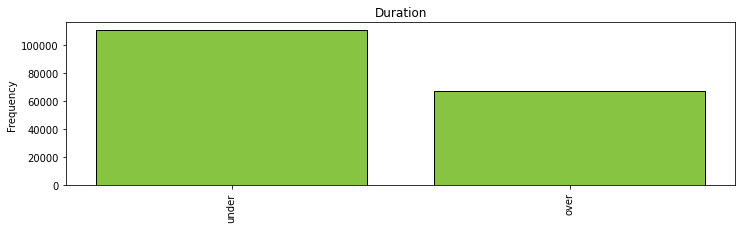

In [190]:
bar_plot(df, categorical)

##### Numerical Data

In [230]:
# Which data needs to be plotted categorical and which numerical
numerical = ['goal', 'converted_pledged_amount']

In [ ]:
df['goal'] = df[np.abs(df.goal-df.goal.mean()) <= (3*df.goal.std())]

In [ ]:
177603.0

In [255]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[[c]],25)
        # 3rd quartile
        Q3 = np.percentile(df[[c]],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indices
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indices
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers


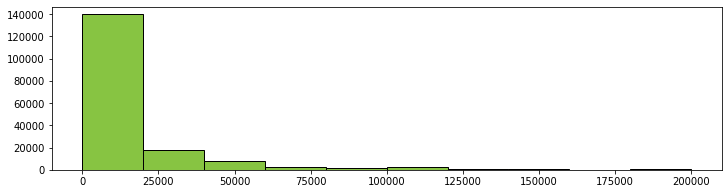

In [241]:
plt.figure(figsize = (12,3))
plt.hist(df['goal'], bins = None, facecolor = '#87c442', edgecolor = 'black', range = [0.0,200000])

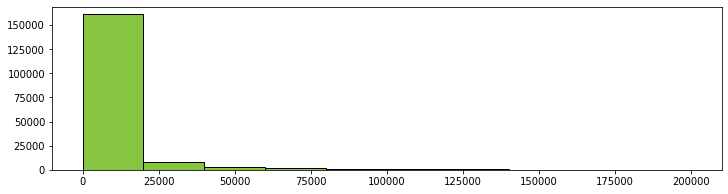

In [242]:
plt.figure(figsize = (12,3))
plt.hist(df['converted_pledged_amount'], bins = None, facecolor = '#87c442', edgecolor = 'black', range = [0.0,200000]);

##### Misc

In [ ]:
# Drop id (not needed anymore)
df.drop('id', axis = 1, inplace = True)
# Drop disable communication as well, only false values
# Drop usd_pledged

# Replace successful and failed entries
df.replace(['successful','failed'],[1,0], inplace=True)

#### One-hot encoding

In [ ]:
# One hot encode all categorical data (country, currency, staff_pick, categories, disable_communication, duration) boolean values might 
# need to be changed to 0,1 in column; includes: duration, disable_communication, staff_pick
one_hot_featurelist = ['country', 'currency', 'disable_communication', 'staff_pick', 'categories', 'duration']
one_hot = pd.get_dummies(df[one_hot_featurelist])
df.drop(one_hot_featurelist, axis = 1, inplace=True)
df = df.join(one_hot)

#### Scalerize

In [ ]:
def scalerize(df, column):
    """Function that scalerizes the data with a min_max scaler

    Args:
        df (dataframe): Dataframe
        column (object): Name or list of names including the columns which should be normalized

    Returns:
        Dataframe object: Returns the dataframe including the normalized columns
    """
    scaler = MinMaxScaler()
    for i in column:
        scaler.fit(df[[i]])
        df[i] = scaler.transform(df[[i]])
    
    return df


In [ ]:
# Standardize nummerical data
nummerical = ['goal','converted_pledged_amount','usd_pledged']
df = scalerize(df, nummerical)